# 1 

![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0003.jpg)


![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0004.jpg)

In [236]:
import numpy as np
from scipy.optimize import minimize

def sigmoid(x):
    return 1./(1. + np.exp(-x))

def get_posterior_parameters(X, y, A):
# get w_map
    def f(w):
        sigmas = y * (X @ w[:, None])
        sigmas = np.sum(np.log(sigmoid(sigmas)).T)
        rez = sigmas - 0.5 * (w[:, None].T @ A @ w[:, None])
        return -rez
    w_map = minimize(f, x0 = np.zeros((X.shape[1])))
    w_map = w_map.x

# get H_inv
    sigmas_plus = sigmoid(y * (X @ w_map[:, None]))
    sigmas_minus = sigmoid( - y * (X @ w_map[:, None]))

    rez_tmp =  A
    for i in range(X.shape[0]):
        rez_tmp = rez_tmp + sigmas_plus[i] * sigmas_minus[i] * X[i][:, None] @ X[i][None, :]
    return w_map, rez_tmp

def predict(X, w_map):
    rez = sigmoid(X @ w_map)
    return rez[:, None]
def sample_predict(X, w_map, H_inv, n_samples = 30000):
    H = np.linalg.inv(H_inv)
    rez = np.zeros((X.shape[0],1))
    for _ in range(n_samples):
        w = np.random.multivariate_normal(w_map, H, 1)
        rez += sigmoid(X @ w.T)
    rez = rez / n_samples
    return rez

def evaluation_metrics(y, probs):
    likelihood = np.prod((probs ** (y > 0)) * (((1 - probs) ** (y < 0))))
    confidence = np.sum(np.abs(probs - 0.5))
    return likelihood, confidence

In [197]:
import numpy as np

vec_size = 3
elems = 1000
A = np.eye(vec_size)

X = np.random.randn(elems, vec_size)
w = np.random.randn(vec_size, 1)
y = 2 * (np.random.rand(elems, 1) < sigmoid(X@w)) - 1


In [198]:
print('тест на работоспособность')
w_map, H_inv = get_posterior_parameters(X, y, A)

preds = sample_predict(X, w_map, H_inv)
print(np.sum((preds > 0.5) == (y > 0.5)))

preds = predict(X, w_map)
print(np.sum((preds > 0.5) == (y > 0.5)))

тест на работоспособность
690
690


## эксперименты

семплированием оцениваем результаты показываемые MAP и полным байесом. Для этого фиксируется w, X_train, y_train и при разных размерах выборки 20 раз семплируется тестовая выборка и  тестовые метки, результат для этого размера тренировочной выборки усредняется. Cкорее всего нужно больше раз семплировать, но эксперимент и так работает долго

In [254]:
from joblib import Parallel, delayed

m_s = list(range(50, 101, 20)) + list(range(200, 1501, 400))
m2 = 1000
sigma = 1
n = 10

A = np.eye(n)

# замораживаем веса и тестовые данные. Для разных размеров тестовой выборки будут использоваться один и тот же тестовый набор

w = np.random.multivariate_normal(np.zeros(n), np.linalg.inv(A), size = 1).T

X_test =  np.random.multivariate_normal(np.zeros(n), np.eye(n), size = m2)
y_test = 2 * np.random.binomial(1, sigmoid(X_test @ w)) - 1

def test_on_dataset(m, m2, samples = 20):
    rez = np.array([0.] * 4)
    # семплируем данные 
    for _ in range(samples):
        X_train = np.random.multivariate_normal(np.zeros(n), np.eye(n), size = m)
        
        y_train = 2 * np.random.binomial(1, sigmoid(X_train @ w)) - 1

        # применяем модель
        w_map, H_inv = get_posterior_parameters(X_train, y_train, A)

        preds_map = predict(X_test, w_map)
        preds_sample = sample_predict(X_test, w_map, H_inv, n_samples= 200_000)
        rez += [*evaluation_metrics(y_test, preds_map), *evaluation_metrics(y_test, preds_sample)]
    return rez / samples

rez = []

test_on_dataset_parall = delayed(test_on_dataset)

rez = Parallel(n_jobs=7)(test_on_dataset_parall(m, m2) for m in m_s)


In [255]:
rez

[array([1.00878339e-154, 3.06408937e+002, 6.48751128e-166, 2.67806501e+002]),
 array([5.86830576e-145, 3.18175426e+002, 1.64340788e-151, 2.87721054e+002]),
 array([2.70756160e-143, 3.27502932e+002, 1.11758382e-147, 3.03425893e+002]),
 array([1.77756373e-136, 3.40038895e+002, 7.78487307e-138, 3.28562328e+002]),
 array([1.50813166e-132, 3.50530360e+002, 4.92055969e-133, 3.46435275e+002]),
 array([5.60462323e-132, 3.54246310e+002, 4.20641688e-132, 3.51748555e+002]),
 array([1.76719503e-131, 3.57484165e+002, 1.23058308e-131, 3.55683665e+002])]

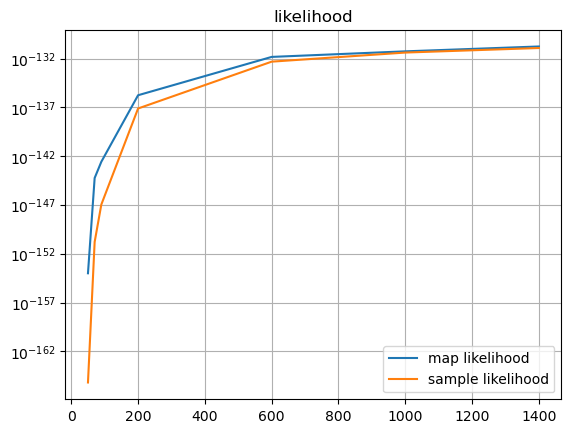

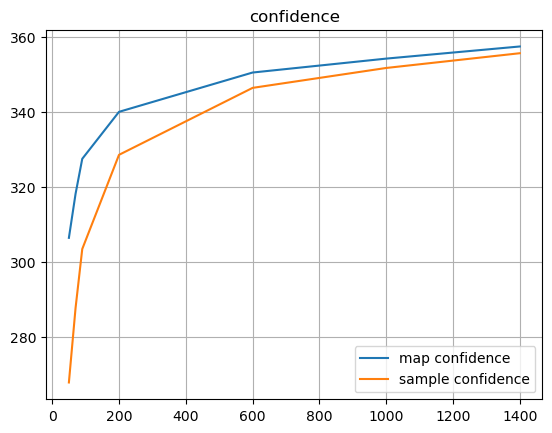

In [256]:
import matplotlib.pyplot as plt
map_likelihood = [rez[i][0] for i in range(len(m_s))]
map_conf = [rez[i][1] for i in range(len(m_s))]
sample_likelihood = [rez[i][2] for i in range(len(m_s))]
sample_conf = [rez[i][3] for i in range(len(m_s))]

plt.plot(m_s, map_likelihood, label = 'map likelihood' )
plt.plot(m_s, sample_likelihood, label = 'sample likelihood')
plt.yscale('log')
plt.title('likelihood')
plt.grid()
plt.legend()
plt.show()
plt.plot(m_s, map_conf, label = 'map confidence')
plt.plot(m_s, sample_conf, label = 'sample confidence')
plt.title('confidence')
plt.grid()
plt.legend()
plt.show()

Видим, что у MAP классификатора уверенность больше. То есть может возникать overconfidence. В этом плане полный байесовский классификатор лучше. Однако в экспериментах получилось, что у MAP классификатора и likelihood больше, что неожиданно.

На практике я бы использовал MAP классфикатор, если нужно считать именно принадлежность к классам, а  вероятности не нужны. Если нужна оценка вероятностей, то лучше использовать честный байесовский классификатор

# 2 


![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0005.jpg)

![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0006.jpg)

![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0007.jpg)

![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0008.jpg)

![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0009.jpg)

# 3
![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0010.jpg)

![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0011.jpg)

![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0012.jpg)

# 4

![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0013.jpg)

![Alt text](./ilovepdf_pages-to-jpg/3%20задание%20Байес%20Латыпов_page-0014.jpg)